<a href="https://colab.research.google.com/github/deenukhan/airbnb_new_user_bookings_case_study/blob/main/stacking_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About Data

<p>In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be.&nbsp;All the users in this dataset are from&nbsp;the USA.</p>

<p>There are 12 possible outcomes of the destination country:&nbsp;'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and&nbsp;'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.</p>

<p>The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after <strong>7/1/2014 (note: this is updated on 12/5/15 when the competition restarted)</strong>.&nbsp;In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010.&nbsp;</p>

<h3>Data Files descriptions</h3>
<ul>
<li><strong>train_users.csv</strong>&nbsp;- the training set of users</li>
<li><strong>test_users.csv</strong> - the test set of users</li>
<ul>
<li>id: user id</li>
<li>date_account_created: the date of account creation</li>
<li>timestamp_first_active: timestamp of the first activity, note that it can be earlier than&nbsp;date_account_created or&nbsp;date_first_booking because a user can search before signing up</li>
<li>date_first_booking: date of first booking</li>
<li>gender</li>
<li>age</li>
<li>signup_method</li>
<li>signup_flow:&nbsp;the page a user came to signup up from</li>
<li>language: international language preference</li>
<li>affiliate_channel:&nbsp;what kind of paid marketing</li>
<li>affiliate_provider:&nbsp;where the marketing is e.g. google, craigslist, other</li>
<li>first_affiliate_tracked:&nbsp;whats the first marketing the user interacted with before the signing up</li>
<li>signup_app</li>
<li>first_device_type</li>
<li>first_browser</li>
<li>country_destination: this is the <strong>target variable</strong> you are to predict</li>
</ul>
<li><strong>sessions.csv</strong> -&nbsp;web sessions log for users</li>
<ul>
<li>user_id: to be joined with the column 'id' in users table</li>
<li>action</li>
<li>action_type</li>
<li>action_detail</li>
<li>device_type</li>
<li>secs_elapsed</li>
</ul>
<li><strong>countries.csv&nbsp;</strong>- summary statistics of destination countries in this dataset and their locations</li>
<li><strong>age_gender_bkts.csv</strong> - summary statistics of users' age group, gender, country of destination</li>
<li><strong>sample_submission.csv</strong> -&nbsp;correct format for submitting your predictions</li>
</ul>

## Extracting Data

In [ ]:
#Below code is just to copy all the files into current session's drive and creating and deleting few required folders

import os
import zipfile
from tqdm import tqdm

!mkdir airbnb_data
!mkdir temp
!cp "/content/drive/My Drive/Study/Case Study 1/airbnb_data/airbnb_data.zip" /content/

#-q is oppsoite of verbose, -d for decompressing to directory
!unzip -q /content/airbnb_data.zip -d /content/temp/

for zip_files in tqdm(os.listdir('/content/temp')):
    path = os.path.join("/content/temp", zip_files)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall("/content/airbnb_data")
    os.remove(path)

os.remove("/content/airbnb_data.zip")
os.rmdir("/content/temp")

100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


## Reading the Data

In [ ]:
#Importing Libraries
#Importing Libraries
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer

#Base Learners
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [ ]:
#Reading the data
age_gender = pd.read_csv('/content/airbnb_data/age_gender_bkts.csv')
countries = pd.read_csv('/content/airbnb_data/countries.csv')
sessions = pd.read_csv('/content/airbnb_data/sessions.csv')
train_users = pd.read_csv('/content/airbnb_data/train_users_2.csv')
test_users = pd.read_csv('/content/airbnb_data/test_users.csv')

## Data Perpartation

In [ ]:
'''First Let's combine both the dataset, train and test and then perform all data preproccesing steps and Encodings.
   I beleive this would cause data leakage Problem, but as we are solving kaggle compettion, I need to focus more 
   on getting highest score, Please suggest if i should not do such thing ? '''

train_test = pd.concat(((train_users.drop(['id', 'country_destination', 'date_first_booking'], axis= 1)), 
                             (test_users.drop(['id', 'date_first_booking'], axis= 1))), axis = 0)

In [ ]:
'''For the First Try, I have taken everthing simple, no complex impuations, all just straight forward.
   Going ahead we'll try more advance approached for imputations.
   Here I am just, Imputing Null values and dealing with some unwanted values in columns'''

#creating object of SimpleImputer
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer()

#First doing some data cleaning
train_test['gender'].replace({'-unknown-':np.nan}, inplace = True)
train_test['first_browser'].replace({'-unknown-':np.nan}, inplace = True)
train_test['age'] = train_test['age'].apply(lambda age : np.nan if (age > 90 or age<18) else age)

#Doing Imputation of gender, first_browser, first_affiliate_tracked, age
train_test['gender'] = imputer_cat.fit_transform(train_test['gender'].values.reshape(-1, 1))
train_test['first_browser'] = imputer_cat.fit_transform(train_test['first_browser'].values.reshape(-1, 1))
train_test['first_affiliate_tracked'] = imputer_cat.fit_transform(train_test['first_affiliate_tracked'].values.reshape(-1, 1))
train_test['age'] = imputer_num.fit_transform(train_test['age'].values.reshape(-1, 1))

In [ ]:
'''First we will be using date_account_created feature only, for that also we will create
   3 new features dac_day, dac_month, dac_year.'''

#First Converting feature into datetime object and then creating other features
train_test['date_account_created'] = pd.to_datetime(train_test['date_account_created'])
train_test['dac_day'] =  train_test['date_account_created'].apply(lambda date : date.day)
train_test['dac_month'] =  train_test['date_account_created'].apply(lambda date : date.month)
train_test['dac_year'] =  train_test['date_account_created'].apply(lambda date : date.year)

In [ ]:
''' For now i will work only with these features just for simplicity, and later will increase complexity gradually
        'dac_day', 'dac_month', 'dac_year', 'signup_flow', 'age', 
        'signup_method', 'gender',
        'language', 'affiliate_channel', 'affiliate_provider',
        'first_affiliate_tracked', 'signup_app', 'first_device_type',
        'first_browser' '''

#dealing with categorical_variables
ohe = OneHotEncoder()

signup_method_ohe = ohe.fit_transform(train_test['signup_method'].values.reshape(-1,1)).toarray()
gender_ohe = ohe.fit_transform(train_test['gender'].values.reshape(-1,1)).toarray()
language_ohe = ohe.fit_transform(train_test['language'].values.reshape(-1,1)).toarray()
affiliate_channel_ohe = ohe.fit_transform(train_test['affiliate_channel'].values.reshape(-1,1)).toarray()
affiliate_provider_ohe = ohe.fit_transform(train_test['affiliate_provider'].values.reshape(-1,1)).toarray()
first_affiliate_tracked_ohe = ohe.fit_transform(train_test['first_affiliate_tracked'].values.reshape(-1,1)).toarray()
signup_app_ohe = ohe.fit_transform(train_test['signup_app'].values.reshape(-1,1)).toarray()
first_device_type_ohe = ohe.fit_transform(train_test['first_device_type'].values.reshape(-1,1)).toarray()
first_browser_ohe = ohe.fit_transform(train_test['first_browser'].values.reshape(-1,1)).toarray()

#Getting teh labels for Target Classs
le = LabelEncoder()
y = le.fit_transform(train_users['country_destination'])

In [ ]:
#Now Just Combining All the Independent Features and for modeling
train_test_values = np.concatenate((signup_method_ohe, gender_ohe, language_ohe, affiliate_channel_ohe,
                     affiliate_provider_ohe, first_affiliate_tracked_ohe, signup_app_ohe,
                    first_device_type_ohe, first_browser_ohe, train_test['dac_day'].values.reshape(-1, 1),
                    train_test['dac_month'].values.reshape(-1, 1), train_test['dac_year'].values.reshape(-1, 1),
                    train_test['signup_flow'].values.reshape(-1, 1), train_test['age'].values.reshape(-1, 1)),
                    axis = 1)

In [ ]:
#Her we're just splitting our training and test datapoints
X = train_test_values[:train_users.shape[0]]
X_test_final = train_test_values[train_users.shape[0]:]
X.shape, y.shape, X_test_final.shape

((213451, 138), (213451,), (62096, 138))

### NDCG Score Calculation : 
I have taken below function [NDCG Scorer](https://www.kaggle.com/davidgasquez/ndcg-scorer) Kaggle Kernel, **I am not sure if i can use this function in my Notebook, for now i just used it, please guide me if i need to write such Function myself?**

In [ ]:
"""Metrics to compute the model performance."""

import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer


def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

## Stacking Classifier

In [ ]:
"""Metrics to compute the model performance."""

import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer


def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
!cp "/content/drive/My Drive/Study/Case Study 1/airbnb_data/X.csv" /content/
!cp "/content/drive/My Drive/Study/Case Study 1/airbnb_data/y.csv" /content/

In [ ]:
X = np.array(pd.read_csv('X.csv'))
y = np.array(pd.read_csv('y.csv')).reshape(-1)

In [ ]:
# First splitting our training data into 80-20 train and test respectively
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 10, stratify = y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#Now let's divide our dataset into 2 equal parts 50 - 50
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_train, y_train , test_size = 0.5, random_state = 10, stratify = y_train)
print(X_train_50.shape, y_train_50.shape, X_test_50.shape, y_test_50.shape)

(170760, 138) (170760,) (42691, 138) (42691,)
(85380, 138) (85380,) (85380, 138) (85380,)


In [ ]:
''' Approach : I will work on X_train_50 and y_train_50, 
    from this dataset i will be creating 10 datasets with sampling with replacement.
    Now i will train 10 models on each of these datasets, and will predict on X_test_50
    will all these 10 model, now i will be having 10 columns of predictions of each Model and i will make the dataset of 
    these predictions and y_test_50 as target variable. and this model will be my meta classifier or final model. '''

#"random_samples_generator" this function basically generates the indexes of raondom samples with replacement
def random_samples_generator():
    """ 
    Generating 60 % Unique Indexes of our total data, 
    and in next step we will generate 40% of Indexes of our total data, from this 60% indexes
    with replacement.
    "Its Your Choice, weather you wanna take first 60% Unique data points or not", 
    you can take all data with duplicate data points if you want.    
    
    """   
    #Below two lines of code performs row sampling
    X_sample_indexes = np.random.choice(np.arange(len(X_train_50)), 
                                        size = int(len(X_train_50)/100 * 60), replace = False)

    #Generating 40% Indexes from above 60% of Indexes with duplicate indexes
    X_sample_indexes = np.append(X_sample_indexes, np.random.choice(X_sample_indexes, 
                                size = int(len(X_train_50)/100 * 60)))
    
    #Below lines of code is used for column sampling
    #Now Generating a Random Variable between 80(included) and 139(excluded)
    #Which is basically Number Columns We are gonna take for current Sample
    random_columns = np.random.randint(80, 139)

    #Now Column Sampling is being done
    sample_columns = np.random.choice(np.arange(138), size = random_columns, replace = False)

    return X_sample_indexes, sample_columns

### Decision Tree - Base Learner

In [ ]:
#Below dataframe is to hold the predictions made by base learners, later we will use these prediction to train meta model
base_model_pred = pd.DataFrame()

#Below dataframe is to hold the columns on which base maodel is trained, we will be needing these column while predicting on test data
base_model_cols = pd.DataFrame()

In [ ]:
#Here we're using GridSearchCv to find the best hyper parameter
parameters = {'max_depth': [3, 5, 7 , 9, 13]}
clf_decision_tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), n_jobs = -1, 
                   scoring = ndcg_scorer)

#Calling the random_sample_generator for row and column sampling indexes
sample_index, sample_columns =  random_samples_generator()

clf_decision_tree.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
print(clf_decision_tree.best_params_)

{'max_depth': 13}


In [ ]:
#Joining column with comma and storing in dataframe
base_model_cols['decision_tree'] = [",".join([str(x) for x in sample_columns])]
base_model_cols.to_csv('base_model_cols.csv', index = False)

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = DecisionTreeClassifier(max_depth=clf_decision_tree.best_params_['max_depth'])
clf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
y_preds = clf.predict(X_test_50[:, sample_columns])

In [ ]:
#Saving the predictions in dataframe for later use
base_model_pred['decision_tree'] = y_preds
base_model_pred.to_csv('base_model_preds.csv', index = False)

#Saving the model for later use
pickle.dump(clf, open('decision_tree.sav', 'wb'))

### Random Forest - Base Learner

In [ ]:
#Below dataframe is to hold the predictions made by base learners, later we will use these prediction to train meta model
base_model_pred = pd.DataFrame()

#Below dataframe is to hold the columns on which base maodel is trained, we will be needing these column while predicting on test data
base_model_cols = pd.DataFrame()

In [ ]:
#Here we're using GridSearchCv to find the best hyper parameter
parameters = [{'n_estimators': [5,10, 50, 100, 150, 200], 'max_depth': [3, 7, 11, 15, 19]}]
clf_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), n_jobs = -1, 
                   scoring = ndcg_scorer)

#Calling the random_sample_generator for row and column sampling indexes
sample_index, sample_columns =  random_samples_generator()
clf_rf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
print(clf_rf.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 19, 'n_estimators': 200}


In [ ]:
#Joining column with comma and storing in dataframe
base_model_cols['random_forest'] = [",".join([str(x) for x in sample_columns])]
base_model_cols.to_csv('base_model_cols.csv', index = False)

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = RandomForestClassifier(max_depth=clf_rf.best_params_['max_depth'], n_estimators=clf_rf.best_params_['n_estimators'])
clf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
y_preds = clf.predict(X_test_50[:, sample_columns])

In [ ]:
#Saving the predictions in dataframe for later use
base_model_pred['random_forest'] = y_preds
base_model_pred.to_csv('base_model_preds.csv', index = False)

#Saving the model for later use
pickle.dump(clf, open('random_forest.sav', 'wb'))

### ExtraTreeClassifier - Base Learner



In [ ]:
#Below dataframe is to hold the predictions made by base learners, later we will use these prediction to train meta model
base_model_pred = pd.DataFrame()

#Below dataframe is to hold the columns on which base maodel is trained, we will be needing these column while predicting on test data
base_model_cols = pd.DataFrame()

In [ ]:
#Here we're using GridSearchCv to find the best hyper parameter
parameters = [{'n_estimators': [5,10, 50, 100, 150], 'max_depth': [3, 7, 11, 15, 19]}]
clf_etc = GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), n_jobs = -1, 
                   scoring = ndcg_scorer)

#Calling the random_sample_generator for row and column sampling indexes
sample_index, sample_columns =  random_samples_generator()
clf_etc.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
print(clf_etc.best_params_)

{'max_depth': 19, 'n_estimators': 50}


In [ ]:
#Joining column with comma and storing in dataframe
base_model_cols['extra_tree'] = [",".join([str(x) for x in sample_columns])]
base_model_cols.to_csv('base_model_cols.csv', index = False)

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = ExtraTreesClassifier(max_depth=clf_etc.best_params_['max_depth'], n_estimators=clf_etc.best_params_['n_estimators'])
clf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
y_preds = clf.predict(X_test_50[:, sample_columns])

In [ ]:
#Saving the predictions in dataframe for later use
base_model_pred['extra_tree'] = y_preds
base_model_pred.to_csv('base_model_preds.csv', index = False)

#Saving the model for later use
pickle.dump(clf, open('extra_tree.sav', 'wb'))

### KNeighbors - Base Learner

In [ ]:
#Below dataframe is to hold the predictions made by base learners, later we will use these prediction to train meta model
base_model_pred = pd.DataFrame()

#Below dataframe is to hold the columns on which base maodel is trained, we will be needing these column while predicting on test data
base_model_cols = pd.DataFrame()

In [ ]:
#Here we're using GridSearchCv to find the best hyper parameter
parameters = [{'n_neighbors': [3, 5, 7, 9, 13 ] }]
clf_knn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), n_jobs = -1, 
                   scoring = ndcg_scorer)

#Calling the random_sample_generator for row and column sampling indexes
sample_index, sample_columns =  random_samples_generator()
clf_knn.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
print(clf_knn.best_params_)

{'n_neighbors': 3}


In [ ]:
#Joining column with comma and storing in dataframe
base_model_cols['knn'] = [",".join([str(x) for x in sample_columns])]
base_model_cols.to_csv('base_model_cols.csv', index = False)

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = KNeighborsClassifier(n_neighbors=clf_knn.best_params_['n_neighbors'])
clf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
y_preds = clf.predict(X_test_50[:, sample_columns])

In [ ]:
#Saving the predictions in dataframe for later use
base_model_pred['knn'] = y_preds
base_model_pred.to_csv('base_model_preds.csv', index = False)

#Saving the model for later use
pickle.dump(clf, open('knn.sav', 'wb'))

### Naive Bayes - Base Learner

In [ ]:
#Below dataframe is to hold the predictions made by base learners, later we will use these prediction to train meta model
base_model_pred = pd.DataFrame()

#Below dataframe is to hold the columns on which base maodel is trained, we will be needing these column while predicting on test data
base_model_cols = pd.DataFrame()

In [ ]:
#Here we're using GridSearchCv to find the best hyper parameter
parameters = {'alpha': [10, 100, 150, 200, 300, 400, 500]}
clf_nb = GridSearchCV(estimator = BernoulliNB(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), n_jobs = -1, 
                   scoring = ndcg_scorer)

#Calling the random_sample_generator for row and column sampling indexes
sample_index, sample_columns =  random_samples_generator()
clf_nb.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
print(clf_nb.best_params_)

{'alpha': 150}


In [ ]:
#Joining column with comma and storing in dataframe
base_model_cols['naive_bayes'] = [",".join([str(x) for x in sample_columns])]
base_model_cols.to_csv('base_model_cols.csv', index = False)

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = BernoulliNB(alpha=clf_nb.best_params_['alpha'],)
clf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
y_preds = clf.predict(X_test_50[:, sample_columns])

In [ ]:
#Saving the predictions in dataframe for later use
base_model_pred['naive_bayes'] = y_preds
base_model_pred.to_csv('base_model_preds.csv', index = False)

#Saving the model for later use
pickle.dump(clf, open('naive_bayes.sav', 'wb'))

### Logistic Regression - Base Learner

In [ ]:
#Below dataframe is to hold the predictions made by base learners, later we will use these prediction to train meta model
base_model_pred = pd.DataFrame()

#Below dataframe is to hold the columns on which base maodel is trained, we will be needing these column while predicting on test data
base_model_cols = pd.DataFrame()

In [ ]:
#Training the model
sample_index, sample_columns =  random_samples_generator()
clf_rf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = LogisticRegression( multi_class='multinomial', max_iter=10000, C=0.1)
clf.fit(X_train_50[sample_index][:, sample_columns], y_train_50[sample_index])
y_preds = clf.predict(X_test_50[:, sample_columns])

In [ ]:
#Joining column with comma and storing in dataframe
base_model_cols['log_reg'] = [",".join([str(x) for x in sample_columns])]
base_model_cols.to_csv('base_model_cols.csv', index = False)

In [ ]:
#Saving the predictions in dataframe for later use
base_model_pred['log_reg'] = y_preds
base_model_pred.to_csv('base_model_preds.csv', index = False)

#Saving the model for later use
pickle.dump(clf, open('log_reg.sav', 'wb'))

### Meta Classifier

In [ ]:
base_model_preds = pd.read_csv('/content/drive/MyDrive/Study/Case Study 1/Saved_Models/base_model_preds.csv')

In [ ]:
#For the Meta Classifier we will be using XGBClassifier, and will be using GridSearchCv for Hyper parameter tuning
parameters = [{'n_estimators': [50, 100, 150, 200], 'max_depth': [3, 7, 11, 15, 19]}]
clf_meta = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), 
                   scoring = ndcg_scorer)

#let's fit our metaclassifer on predicted values of base classifiers and predict the values 
clf_meta.fit(np.array(base_model_preds), y_test_50)
clf_meta.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [ ]:
#Now When we have our best hyper paramter let's train our model and predicting
clf = xgb.XGBClassifier(max_depth=clf_meta.best_params_['max_depth'], n_estimators=clf_meta.best_params_['n_estimators'])
clf.fit(np.array(base_model_preds), y_test_50)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Saving the model for later use
pickle.dump(clf, open('meta_xgb.sav', 'wb'))

In [ ]:
#For the Meta Classifier we will be using RandomForestClassifier, and will be using GridSearchCv for Hyper parameter tuning
parameters = [{'n_estimators': [50, 100, 150, 200], 'max_depth': [3, 7, 11, 15, 19]}]
clf_meta = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, 
                   cv = KFold(n_splits = 5, shuffle = True, random_state= 134), 
                   scoring = ndcg_scorer)

#let's fit our metaclassifer on predicted values of base classifiers and predict the values 
clf_meta.fit(np.array(base_model_pred), y_test_50)
clf_meta.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [ ]:
#Now, when we have our best hyperparameters let's train our meta model
clf = RandomForestClassifier(max_depth = 7, n_estimators = 200).fit(np.array(base_model_pred), y_test_50)

In [ ]:
#Prediction on Final Test Data
#Now We are creating one dataframe of prediction of each model on our final testing dataset
base_model_pred_test = pd.DataFrame()
for model_name, model in model_dict.items():
    base_model_pred_test[model_name] = model_dict[model_name][0].predict(X_test_final[:, model_dict[model_name][2]])

y_preds = clf.predict_proba(np.array(base_model_pred_test))

In [ ]:
'''This Code is basically used get top 5 predictions for the submission file
   Here we're just zipping predictions and classes together and sorting with predictions,
   and then taking top5 countries, that's it.'''

prediction_classes = le.classes_
user_list = []
predictions_list = []
for user_index in range(len(test_users)):
    user_list.extend([test_users['id'][user_index]] * 5)
    sorted_values = sorted(zip(y_preds[user_index], prediction_classes), reverse = True)[:5]
    predictions_list.extend([country[1] for country in sorted_values])
    
submission_file = pd.DataFrame({'id':user_list, 'country':predictions_list})
submission_file.to_csv('submission_stacking_3.csv', index = False)

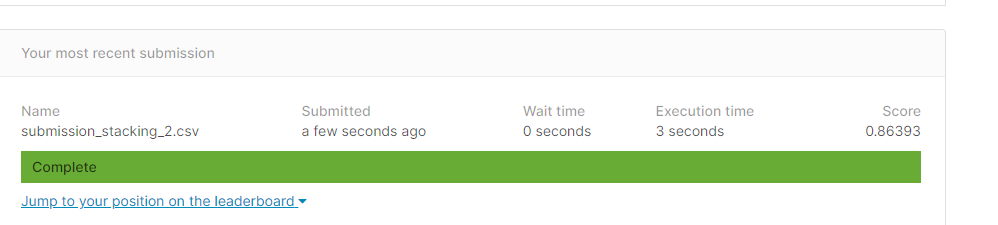

In [ ]:
#Saving Models
for model_name, model in model_dict.items():
    pickle.dump(model, open(model_name, 'wb'))

In [ ]:
#Saving the model for later use
pickle.dump(clf, open('rfc_stacking_86393.sav', 'wb'))

In [ ]:
model1 = pickle.load(open('model1', 'rb'))

In [ ]:
model1

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=124, splitter='best')